In [1]:
import itertools
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

import logging
from numpy import random
import gensim
import nltk

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup
%matplotlib inline

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

Using TensorFlow backend.


In [2]:
df = pd.read_csv('madu.csv')
df = df[pd.notnull(df['CATEGORY'])]
print(df.head(5))
print(df['SENTENCE'].apply(lambda x: len(x.split(' '))).sum())

                                            SENTENCE CATEGORY
0  Tidak menghalang Kaka untuk meneruskan karier ...  manisan
1  Pelakon Sasqia Dahuri yang sah menjadi isteri ...  manisan
2  Sebagai kafe yang mengutamakan status halal, k...  manisan
3  Suspek, yang bekerja sebagai penjual madu dita...  manisan
4  Batu-bata dilekat menggunakan bancuhan campura...  manisan
1686


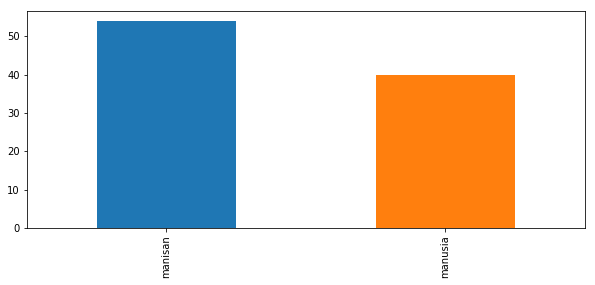

In [4]:
my_tags = ['manisan','manusia']
plt.figure(figsize=(10,4))
df.CATEGORY.value_counts().plot(kind='bar');

In [5]:
def print_plot(index):
    example = df[df.index == index][['SENTENCE', 'CATEGORY']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Tag:', example[1])

print_plot(10)

Wartawan BH memenangi Anugerah Kewartawanan Kesihatan Terbaik 2018 (Akhbar Bahasa Melayu) menerusi rencana bertajuk Madu Diabetes.
Tag: manisan


In [6]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text
    
df['SENTENCE'] = df['SENTENCE'].apply(clean_text)
print_plot(10)

wartawan bh memenangi anugerah kewartawanan kesihatan terbaik 2018 akhbar bahasa melayu menerusi rencana bertajuk madu diabetes
Tag: manisan


In [7]:
df['SENTENCE'].apply(lambda x: len(x.split(' '))).sum()

1660

In [8]:
X = df.SENTENCE
y = df.CATEGORY
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

In [10]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

%time
from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

Wall time: 0 ns
accuracy 0.896551724137931
             precision    recall  f1-score   support

    manisan       0.94      0.89      0.91        18
    manusia       0.83      0.91      0.87        11

avg / total       0.90      0.90      0.90        29



In [11]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

%time

y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

Wall time: 0 ns
accuracy 0.896551724137931
             precision    recall  f1-score   support

    manisan       0.94      0.89      0.91        18
    manusia       0.83      0.91      0.87        11

avg / total       0.90      0.90      0.90        29



In [12]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(X_train, y_train)

%time

y_pred = logreg.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

Wall time: 0 ns
accuracy 0.896551724137931
             precision    recall  f1-score   support

    manisan       0.94      0.89      0.91        18
    manusia       0.83      0.91      0.87        11

avg / total       0.90      0.90      0.90        29



BOW with Keras

In [15]:
train_size = int(len(df) * .7)
train_posts = df['SENTENCE'][:train_size]
train_tags = df['CATEGORY'][:train_size]

test_posts = df['SENTENCE'][train_size:]
test_tags = df['CATEGORY'][train_size:]

max_words = 1000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)
tokenize.fit_on_texts(train_posts) # only fit on train

x_train = tokenize.texts_to_matrix(train_posts)
x_test = tokenize.texts_to_matrix(test_posts)

encoder = LabelEncoder()
encoder.fit(train_tags)
y_train = encoder.transform(train_tags)
y_test = encoder.transform(test_tags)

num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

batch_size = 32
epochs = 10

# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
              
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 58 samples, validate on 7 samples
Epoch 1/10
58/58 [==============================] - 1s 18ms/step - loss: 0.7041 - acc: 0.5345 - val_loss: 0.6431 - val_acc: 0.8571
Epoch 2/10
58/58 [==============================] - 0s 676us/step - loss: 0.5906 - acc: 0.7586 - val_loss: 0.5772 - val_acc: 0.8571
Epoch 3/10
58/58 [==============================] - 0s 729us/step - loss: 0.4677 - acc: 0.9655 - val_loss: 0.5221 - val_acc: 1.0000
Epoch 4/10
58/58 [==============================] - 0s 1ms/step - loss: 0.3819 - acc: 0.9483 - val_loss: 0.4721 - val_acc: 1.0000
Epoch 5/10
58/58 [==============================] - 0s 730us/step - loss: 0.3131 - acc: 1.0000 - val_loss: 0.4269 - val_acc: 1.0000
Epoch 6/10
58/58 [==============================] - 0s 720us/step - loss: 0.2604 - acc: 1.0000 - val_loss: 0.3901 - val_acc: 1.0000
Epoch 7/10
58/58 [==============================] - 0s 858us/step - loss: 0.2204 - acc: 1.0000 - val_loss: 0.3565 - val_acc: 1.0000
Epoch 8/10
58/58 [==================

In [16]:
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score[1])

29/29 [==============================] - 0s 373us/step
Test accuracy: 1.0


In [31]:
# These are the labels we stored from our training
# The order is very important here.
from pathlib import Path
# from keras.preprocessing.text import Tokenizer

# labels = np.array(['alt.atheism', 'comp.graphics'])
labels = my_tags
test_files = ["C:\\Users\\ifa\\Project_DeepLearn\\madu_test.txt",
              "C:\\Users\\ifa\\Project_DeepLearn\\madu_test2.txt"]
x_data = []
for t_f in test_files:
    t_f_data = Path(t_f).read_text()
    x_data.append(t_f_data)

x_data_series = pd.Series(x_data)
x_tokenized = tokenize.texts_to_matrix(x_data_series, mode='tfidf')

i=0
for x_t in x_tokenized:
    prediction = model.predict(np.array([x_t]))
    predicted_label = labels[np.argmax(prediction[0])]
    print("File ->", test_files[i], "Predicted label: " + predicted_label)
    i += 1

File -> C:\Users\ifa\Project_DeepLearn\madu_test.txt Predicted label: manusia
File -> C:\Users\ifa\Project_DeepLearn\madu_test2.txt Predicted label: manisan


In [34]:
import pickle
from keras.preprocessing.text import Tokenizer

# creates a HDF5 file 'my_model.h5'
model.model.save('my_model.h5')
 
# Save Tokenizer i.e. Vocabulary
with open('tokenize.pickle', 'wb') as handle:
    pickle.dump(tokenize, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [35]:
encoder.classes_ #LabelBinarizer

array(['manisan', 'manusia'], dtype=object)

In [36]:
labels = encoder.classes_
test_files = ["C:\\Users\\ifa\\Project_DeepLearn\\madu_test.txt",
              "C:\\Users\\ifa\\Project_DeepLearn\\madu_test2.txt"]
x_data = []
for t_f in test_files:
    t_f_data = Path(t_f).read_text()
    x_data.append(t_f_data)

x_data_series = pd.Series(x_data)
x_tokenized = tokenize.texts_to_matrix(x_data_series, mode='tfidf')

i=0
for x_t in x_tokenized:
    prediction = model.predict(np.array([x_t]))
    predicted_label = labels[np.argmax(prediction[0])]
    print("File ->", test_files[i], "Predicted label: " + predicted_label)
    i += 1

File -> C:\Users\ifa\Project_DeepLearn\madu_test.txt Predicted label: manusia
File -> C:\Users\ifa\Project_DeepLearn\madu_test2.txt Predicted label: manisan


In [43]:
labels = encoder.classes_

with open("madu_test.txt", "r") as ins:
    x_data = []
    for line in ins:
        x_data.append(line)

x_data_series = pd.Series(x_data)
x_tokenized = tokenize.texts_to_matrix(x_data_series, mode='tfidf')

i=0
for x_t in x_tokenized:
    prediction = model.predict(np.array([x_t]))
    predicted_label = labels[np.argmax(prediction[0])]
    print("Sentence ->", x_data_series[i], "Predicted label: " + predicted_label, "\n")
    i += 1

Sentence -> Madu Lebih Baik Dari Antibiotik Untuk Rawat Batuk!
 Predicted label: manisan 

Sentence -> Ramai nak jadi madu - isteri Lan Solo
 Predicted label: manusia 

Sentence -> Madu saya anugerah Allah, kata isteri pertama Predicted label: manusia 

